### Optimizers
* Remember, the loss function lets us quantify the quality of our model parameters (i.e. weights $\mathcal{W}$.
* Our goal with optimization is to find the $\mathcal{W}$ that minimizes our loss function.

### Stochastic Gradient Descent
* Minimize an objective function by updating the parameters in the opposite direction of the gradient of the objective function with respect to the parameters.
* Learning rate determines the size of the update steps we take to reach a (local) minimum.
* That is, we follow the direction of the slope of the surface created by our loss function until we reach a valley.
* In standard Gradient Descent, the weights are updated incrementally after each epoch based on the cost gradient computed from the complete training set.
* In stochastic Gradient Descent, however, we update the weights **after each training sample*.
* This is "stochastic" because the gradient from a single training sample is a "stochastic approximation" of the "true" gradient.

### Momentum
* If gradient descent is navigating down a valley with steep sides, it tends to madly oscillate from one valley wall to the other without making much progress down the valley. 
* This is because the largest gradients point up and down the valley walls whereas the gradient along the floor of the valley is quite small. 
* Momentum Optimization attempts to remedy this by keeping track of the prior gradients and if they keep changing direction then damp them, and if the gradients stay in the same direction then reward them. 
* Momentum helps accelerate SGD in the relevant direction, and dampens oscillations by adding a fraction of the update vector of the past time step to the current update vector.
<table><tr><td><img src='../picsfromJune12/sgd_momentum1.png' style="width: 450px"></td><td><img src='../picsfromJune12/sgd_momentum2.png' style="width: 450px"></td></td></tr></table>
* This effectively smooths updates, and can sometimes serve to enhance stability and speed.

### Adagrad
* Adagrad is optimized to find needles in haystacks and for dealing with large sparse matrices. 
* It keeps track of the previous changes and will amplify the changes for weights that change infrequently and suppress the changes for weights that change frequently.

### Adam
* Adaptive Moment Estimation (Adam) keeps separate learning rates for each weight as well as an exponentially decaying average of previous gradients. 
* This combines elements of Momentum and Adagrad together and is fairly memory efficient since it doesn’t keep a history of anything (just the rolling averages). 
* It often works well for both sparse matrices and noisy data.

### RMSprop
* RMSprop is similar to Adam it just uses different moving averages but has the same goals.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tf_custom_optimizers import AddSign, PowerSign
%matplotlib inline
tf.set_random_seed(1)
np.random.seed(1)

LR = 0.01
BATCH_SIZE = 32

# fake data
x = np.linspace(-1, 1, 100)[:, np.newaxis]          # shape (100, 1)
noise = np.random.normal(0, 0.1, size=x.shape)
y = np.power(x, 2) + noise                          # shape (100, 1) + some noise

# plot dataset
# plt.scatter(x, y)
# plt.show()

# default network
class Net:
    def __init__(self, opt, **kwargs):
        self.x = tf.placeholder(tf.float32, [None, 1])
        self.y = tf.placeholder(tf.float32, [None, 1])
        l = tf.layers.dense(self.x, 20, tf.nn.relu)
        out = tf.layers.dense(l, 1)
        self.loss = tf.losses.mean_squared_error(self.y, out)
        self.train = opt(LR, **kwargs).minimize(self.loss)

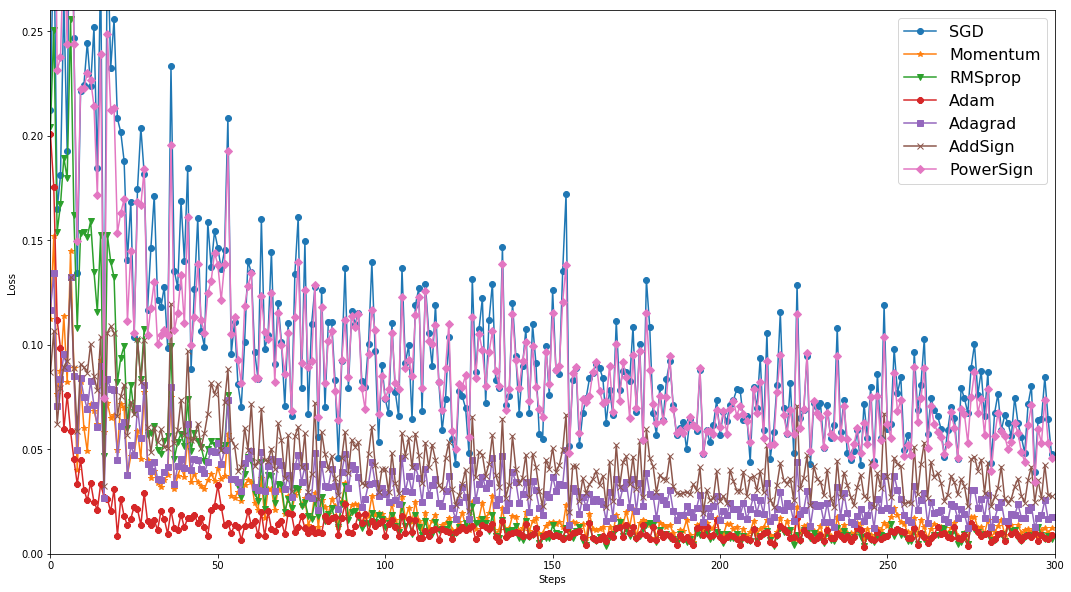

In [8]:
# different nets
net_SGD         = Net(tf.train.GradientDescentOptimizer)
net_Momentum    = Net(tf.train.MomentumOptimizer, momentum=0.9)
net_RMSprop     = Net(tf.train.RMSPropOptimizer)
net_Adam        = Net(tf.train.AdamOptimizer)
net_Adagrad     = Net(tf.train.AdagradOptimizer)
net_AddSign     = Net(AddSign)
net_PowerSign   = Net(PowerSign)

nets = [net_SGD, net_Momentum, net_RMSprop, 
        net_Adam, net_Adagrad, net_AddSign, net_PowerSign]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses_his = [[], [], [], [], [], [], []]   # record loss

# training
for step in range(300):          # for each training step
    index = np.random.randint(0, x.shape[0], BATCH_SIZE)
    b_x = x[index]
    b_y = y[index]

    for net, l_his in zip(nets, losses_his):
        _, l = sess.run([net.train, net.loss], {net.x: b_x, net.y: b_y})
        l_his.append(l)     # loss recoder

# plot loss history
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad','AddSign','PowerSign']
markers = ['o','*','v','8','s','x','D']
plt.figure(figsize=(18,10))
for i, l_his in enumerate(losses_his):
    plt.plot(l_his, label=labels[i], marker=markers[i])
plt.legend(loc='best',fontsize=16)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.26))
plt.xlim((0,300))
plt.show()